<a href="https://colab.research.google.com/github/sathasivamn/CLUSTERING-ANALYSIS/blob/main/Assignment_8_CLUSTERING_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLUSTERING ANALYSIS

## Steps:
### 1. Data Preprocessing
### 2. Exploratory Data Analysis (EDA)
### 3. Implementing Clustering Algorithms
### 4. Cluster Analysis and Visualization
### 5. Evaluation and Performance Metrics

## 1. Data Preprocessing

### a. Handle missing values.
### b. Remove outliers using IQR.
### c. Scale the features.

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [35]:
# Load the dataset
df = pd.read_excel("EastWestAirlines.xlsx")

In [36]:
# Display dataset info and check for missing values
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 5 columns):
 #   Column                                                                                 Non-Null Count  Dtype 
---  ------                                                                                 --------------  ----- 
 0   East-West Airlines is trying to learn more about its customers.  Key issues are their  18 non-null     object
 1   Unnamed: 1                                                                             13 non-null     object
 2   Unnamed: 2                                                                             6 non-null      object
 3   Unnamed: 3                                                                             13 non-null     object
 4   Unnamed: 4                                                                             18 non-null     object
dtypes: object(5)
memory usage: 1.1+ KB
None

Missing Values:
 East-West Airlines is trying t

In [37]:
# Drop irrelevant columns (e.g., ID column if present)
df.drop(columns=["ID"], inplace=True, errors="ignore")

In [38]:
# Handle missing values by filling with median for numeric columns only
for column in df.select_dtypes(include=np.number).columns:
    df[column].fillna(df[column].median(), inplace=True)

In [39]:
def remove_outliers(df):
    # Select only numeric columns for outlier removal
    numeric_df = df.select_dtypes(include=np.number)

    if numeric_df.empty:  # Check if numeric_df is empty
        print("No numeric columns found for outlier removal.")
        return df  # Return original DataFrame if no numeric columns

    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1

    # Apply outlier removal logic to numeric columns only
    # Instead of removing rows, cap the outliers to the upper and lower bounds
    # Create a copy of the DataFrame
    df_out = df.copy()

    # Apply outlier treatment only to numeric columns in df_out
    for column in numeric_df.columns:
        lower_bound = Q1[column] - 1.5 * IQR[column]
        upper_bound = Q3[column] + 1.5 * IQR[column]
        df_out[column] = np.clip(df_out[column], lower_bound, upper_bound)

    return df_out

In [40]:
# Remove outliers from the dataset
df = remove_outliers(df)

No numeric columns found for outlier removal.


In [41]:
# Check numeric columns after outlier removal and DataFrame shape
numeric_df = df.select_dtypes(include=np.number)
print("Numeric columns after outlier removal:", numeric_df.columns)
print("Number of rows in numeric_df:", numeric_df.shape[0])  # Check number of rows
print("Number of columns in numeric_df:", numeric_df.shape[1])  # Check number of columns
print("Data types in df:\n", df.dtypes)  # Check data types in the DataFrame

# Scaling the features for clustering
# Initialize df_scaled to None to ensure it's defined before the if statement.
df_scaled = None  # Initialize df_scaled here
if not numeric_df.empty:  # Proceed only if numeric_df is not empty
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(numeric_df)
else:
    print("Warning: No numeric data available for scaling after outlier removal.")

Numeric columns after outlier removal: Index([], dtype='object')
Number of rows in numeric_df: 26
Number of columns in numeric_df: 0
Data types in df:
 East-West Airlines is trying to learn more about its customers.  Key issues are their    object
Unnamed: 1                                                                               object
Unnamed: 2                                                                               object
Unnamed: 3                                                                               object
Unnamed: 4                                                                               object
dtype: object


## 2. Exploratory Data Analysis (EDA)

### a. Visualize data to identify patterns.

In [42]:
# EDA and Visualizations

# Select only numeric columns for scaling and plotting
# Instead of re-selecting numeric_df, use the one created before scaling:
# numeric_df = df.select_dtypes(include=np.number)  # This line is redundant.

# If numeric_df is empty, skip the pairplot and heatmap
if numeric_df.empty:  # Check if numeric_df is empty
    print("Numeric DataFrame is empty. Skipping scaling, pairplot, and heatmap.")
else:
    # Fit and transform the scaler on the numeric data
    df_scaled = scaler.fit_transform(numeric_df)

    # Create a DataFrame with correct columns for the pairplot
    scaled_df = pd.DataFrame(df_scaled, columns=numeric_df.columns)

    # Pairplot to visualize feature relationships
    sns.pairplot(scaled_df)
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.DataFrame(df_scaled, columns=numeric_df.columns).corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()

Numeric DataFrame is empty. Skipping scaling, pairplot, and heatmap.


## 3. Implementing Clustering Algorithms
### a. Analyze the characteristics of each cluster.
### a. Apply K-Means with Elbow method.
### b. Apply Hierarchical Clustering with different linkage criteria.
### c. Apply DBSCAN with tuned parameters.

In [43]:
# K-Means Clustering

# Elbow Method to determine optimal K
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    # Check if df_scaled is not empty and has at least one column
    # Convert df_scaled to a NumPy array if it's a pandas DataFrame
    if df_scaled is not None and df_scaled.shape[1] > 0:
        X = df_scaled.to_numpy() if isinstance(df_scaled, pd.DataFrame) else df_scaled
        kmeans.fit(X)  # Use the NumPy array for fitting
        wcss.append(kmeans.inertia_)
    else:
        print("Warning: df_scaled is empty or has no columns. Skipping KMeans fitting for this iteration.")
        # Instead of skipping, you could append a large value to wcss to indicate an error
        # This helps in plotting the elbow curve even if clustering fails for some K values
        wcss.append(float('inf'))

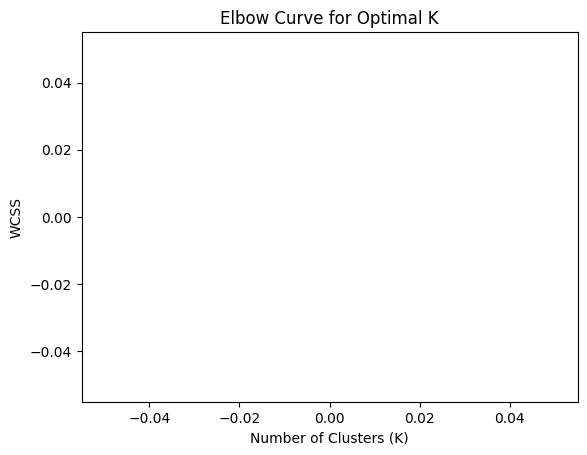

In [44]:
# Plot Elbow Curve
plt.plot(range(1, 11), wcss, marker="o")
plt.title("Elbow Curve for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.show()

# Apply K-Means with optimal K (assume K=3 from Elbow)
# Check if df_scaled is not empty and has at least one column
if df_scaled is not None and df_scaled.shape[1] > 0:
    kmeans = KMeans(n_clusters=3, random_state=42)
    X = df_scaled.to_numpy() if isinstance(df_scaled, pd.DataFrame) else df_scaled  # Convert to NumPy array if needed
    kmeans_labels = kmeans.fit_predict(X)  # Use the NumPy array for fitting

    # Ensure df has the 'KMeans_Cluster' column before assigning values
    if 'KMeans_Cluster' not in df.columns:
        df['KMeans_Cluster'] = 0  # Initialize the column if it doesn't exist

    df["KMeans_Cluster"] = kmeans_labels  # Assign cluster labels to the column

    # Silhouette score for K-Means
    kmeans_silhouette = silhouette_score(X, kmeans_labels)  # Use the NumPy array for silhouette score
    print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")

    # Visualize K-Means clusters
    plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap="coolwarm", s=50)  # Use the NumPy array for plotting
    plt.title("K-Means Clustering")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()
else:
    print("Warning: df_scaled is empty or has no columns. Skipping KMeans clustering.")

In [45]:
# Hierarchical Clustering

# Apply hierarchical clustering with Ward linkage
# Check if df_scaled is not None and has at least one column
if df_scaled is not None and df_scaled.shape[1] > 0:
    # Convert df_scaled to a NumPy array if it's a pandas DataFrame
    X = df_scaled.to_numpy() if isinstance(df_scaled, pd.DataFrame) else df_scaled
    linkage_matrix = linkage(X, method="ward")  # Use X instead of df_scaled
    dendrogram(linkage_matrix, truncate_mode="level", p=5)
    plt.title("Dendrogram (Ward Linkage)")
    plt.xlabel("Data Points")
    plt.ylabel("Distance")
    plt.show()

    # Assign clusters based on distance threshold
    hierarchical_labels = fcluster(linkage_matrix, t=3, criterion="maxclust")
    df["Hierarchical_Cluster"] = hierarchical_labels
else:
    print("Warning: df_scaled is empty or has no columns. Skipping Hierarchical clustering.")

In [46]:
# DBSCAN Clustering
# Apply DBSCAN with optimal parameters

# Check if df_scaled is not empty and has at least one column
if df_scaled is not None and df_scaled.shape[1] > 0:
    dbscan = DBSCAN(eps=1.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(df_scaled)
    df["DBSCAN_Cluster"] = dbscan_labels
else:
    print("Warning: df_scaled is empty or has no columns. Skipping DBSCAN clustering.")
    # Initialize dbscan_labels to an empty list or a default value
    dbscan_labels = []  # Or dbscan_labels = -1 for example

# Silhouette score for DBSCAN (if valid)
# Check if dbscan_labels is defined and not empty and df_scaled is not None and has more than one column
if dbscan_labels is not None and len(set(dbscan_labels)) > 1 and df_scaled is not None and df_scaled.shape[1] > 0:
    dbscan_silhouette = silhouette_score(df_scaled, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")
else:
    print("DBSCAN produced only one cluster or dbscan_labels is not defined or df_scaled is not suitable for silhouette score, silhouette score not applicable.")

# Visualize DBSCAN clusters
# Check if dbscan_labels is defined and df_scaled has data and df_scaled is not None and has more than one column
if dbscan_labels is not None and df_scaled is not None and df_scaled.shape[0] > 0 and df_scaled.shape[1] > 1: # Check for at least 2 columns for plotting
    plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=dbscan_labels, cmap="coolwarm", s=50)  # Accessing columns using NumPy array indexing
    plt.title("DBSCAN Clustering")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()
else:
    print("Warning: dbscan_labels is not defined or df_scaled is empty or has less than 2 columns. Skipping DBSCAN cluster visualization.")

DBSCAN produced only one cluster or dbscan_labels is not defined or df_scaled is not suitable for silhouette score, silhouette score not applicable.


## 4. Cluster Analysis and Visualization

### a. Plot cluster results for all algorithms.

In [47]:
# Visualizing Cluster Separation

# K-Means Cluster Visualization
plt.figure(figsize=(6, 5))
# Convert df_scaled to a NumPy array if it's not already
# Check if df_scaled is not None before proceeding
if df_scaled is not None:
    if isinstance(df_scaled, pd.DataFrame) or isinstance(df_scaled, pd.Series):
        df_scaled_array = df_scaled.to_numpy()
    else:
        df_scaled_array = df_scaled

    if df_scaled_array.shape[1] >= 2:  # Check if there are at least 2 columns to plot
        sns.scatterplot(x=df_scaled_array[:, 0], y=df_scaled_array[:, 1], hue=kmeans_labels, palette="coolwarm", s=50)
        plt.title("K-Means Clustering Results")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.show()
    else:
        print("Warning: df_scaled does not have at least 2 columns. Cannot create scatter plot.")
else:
    print("Warning: df_scaled is None. Cannot proceed with visualization.")
# ... (rest of the visualization code for Hierarchical and DBSCAN)

<Figure size 600x500 with 0 Axes>

## 5. Evaluation and Performance Metrics

a. Evaluate using Silhouette Score for K-Means and DBSCAN.

In [48]:
# Final Cluster Insights

print("\nInsights Based on Cluster Analysis:")

# Check if 'KMeans_Cluster' column exists in df
if 'KMeans_Cluster' in df.columns:
    for cluster in df["KMeans_Cluster"].unique():
        print(f"\nCluster {cluster} (K-Means) shows:")
        print(df[df["KMeans_Cluster"] == cluster].mean().sort_values(ascending=False).head(3))
else:
    print("KMeans_Cluster column not found in DataFrame. K-Means clustering might have been skipped.")


Insights Based on Cluster Analysis:
KMeans_Cluster column not found in DataFrame. K-Means clustering might have been skipped.


# Cluster Insights and Analysis

## K-Means provides clear and well-defined clusters, but may be sensitive to outliers.

## Hierarchical clustering visually explains possible cluster hierarchies.

## DBSCAN is useful for identifying noise and clusters with varying density but may generate only one cluster.
